In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import warnings
warnings.filterwarnings("ignore")

# Here are the Data Source

In [2]:
confirmed_df = pd.read_csv('time_series_covid19_confirmed_CA.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_CA.csv')

In [3]:
confirmed_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,3/10/2021,3/11/2021,3/12/2021,3/13/2021,3/14/2021,3/15/2021,3/16/2021,3/17/2021,3/18/2021,3/19/2021
0,84006001,US,USA,840,6001,Alameda,California,US,37.646294,-121.892927,...,81658,81747,81866,81969,82034,82116,82168,82258,82368,82460
1,84006003,US,USA,840,6003,Alpine,California,US,38.596786,-119.822359,...,85,85,85,85,85,85,85,85,86,86
2,84006005,US,USA,840,6005,Amador,California,US,38.445831,-120.656960,...,3494,3496,3498,3503,3504,3504,3506,3506,3506,3506
3,84006007,US,USA,840,6007,Butte,California,US,39.667278,-121.600525,...,11092,11096,11110,11126,11131,11140,11141,11141,11141,11141
4,84006009,US,USA,840,6009,Calaveras,California,US,38.205371,-120.552913,...,1941,1941,1944,1944,1944,1946,1951,1958,1963,1968


In [4]:
cols = confirmed_df.keys()

In [5]:
confirmed = confirmed_df.loc[:, cols[11]:cols[-1]]


In [6]:
dates = confirmed.keys()
total_cases = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    total_cases.append(confirmed_sum)


In [7]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average


In [8]:
window = 7

In [9]:
# confirmed cases
total_case_avg= moving_average(total_cases, window)
daily_cases = daily_increase(total_cases)
daily_case_avg = moving_average(daily_cases, window)

# Current Pandemic Evaluation

In [10]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
total_cases = np.array(total_cases).reshape(-1, 1)

In [11]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [12]:
start = '1/22/2021'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

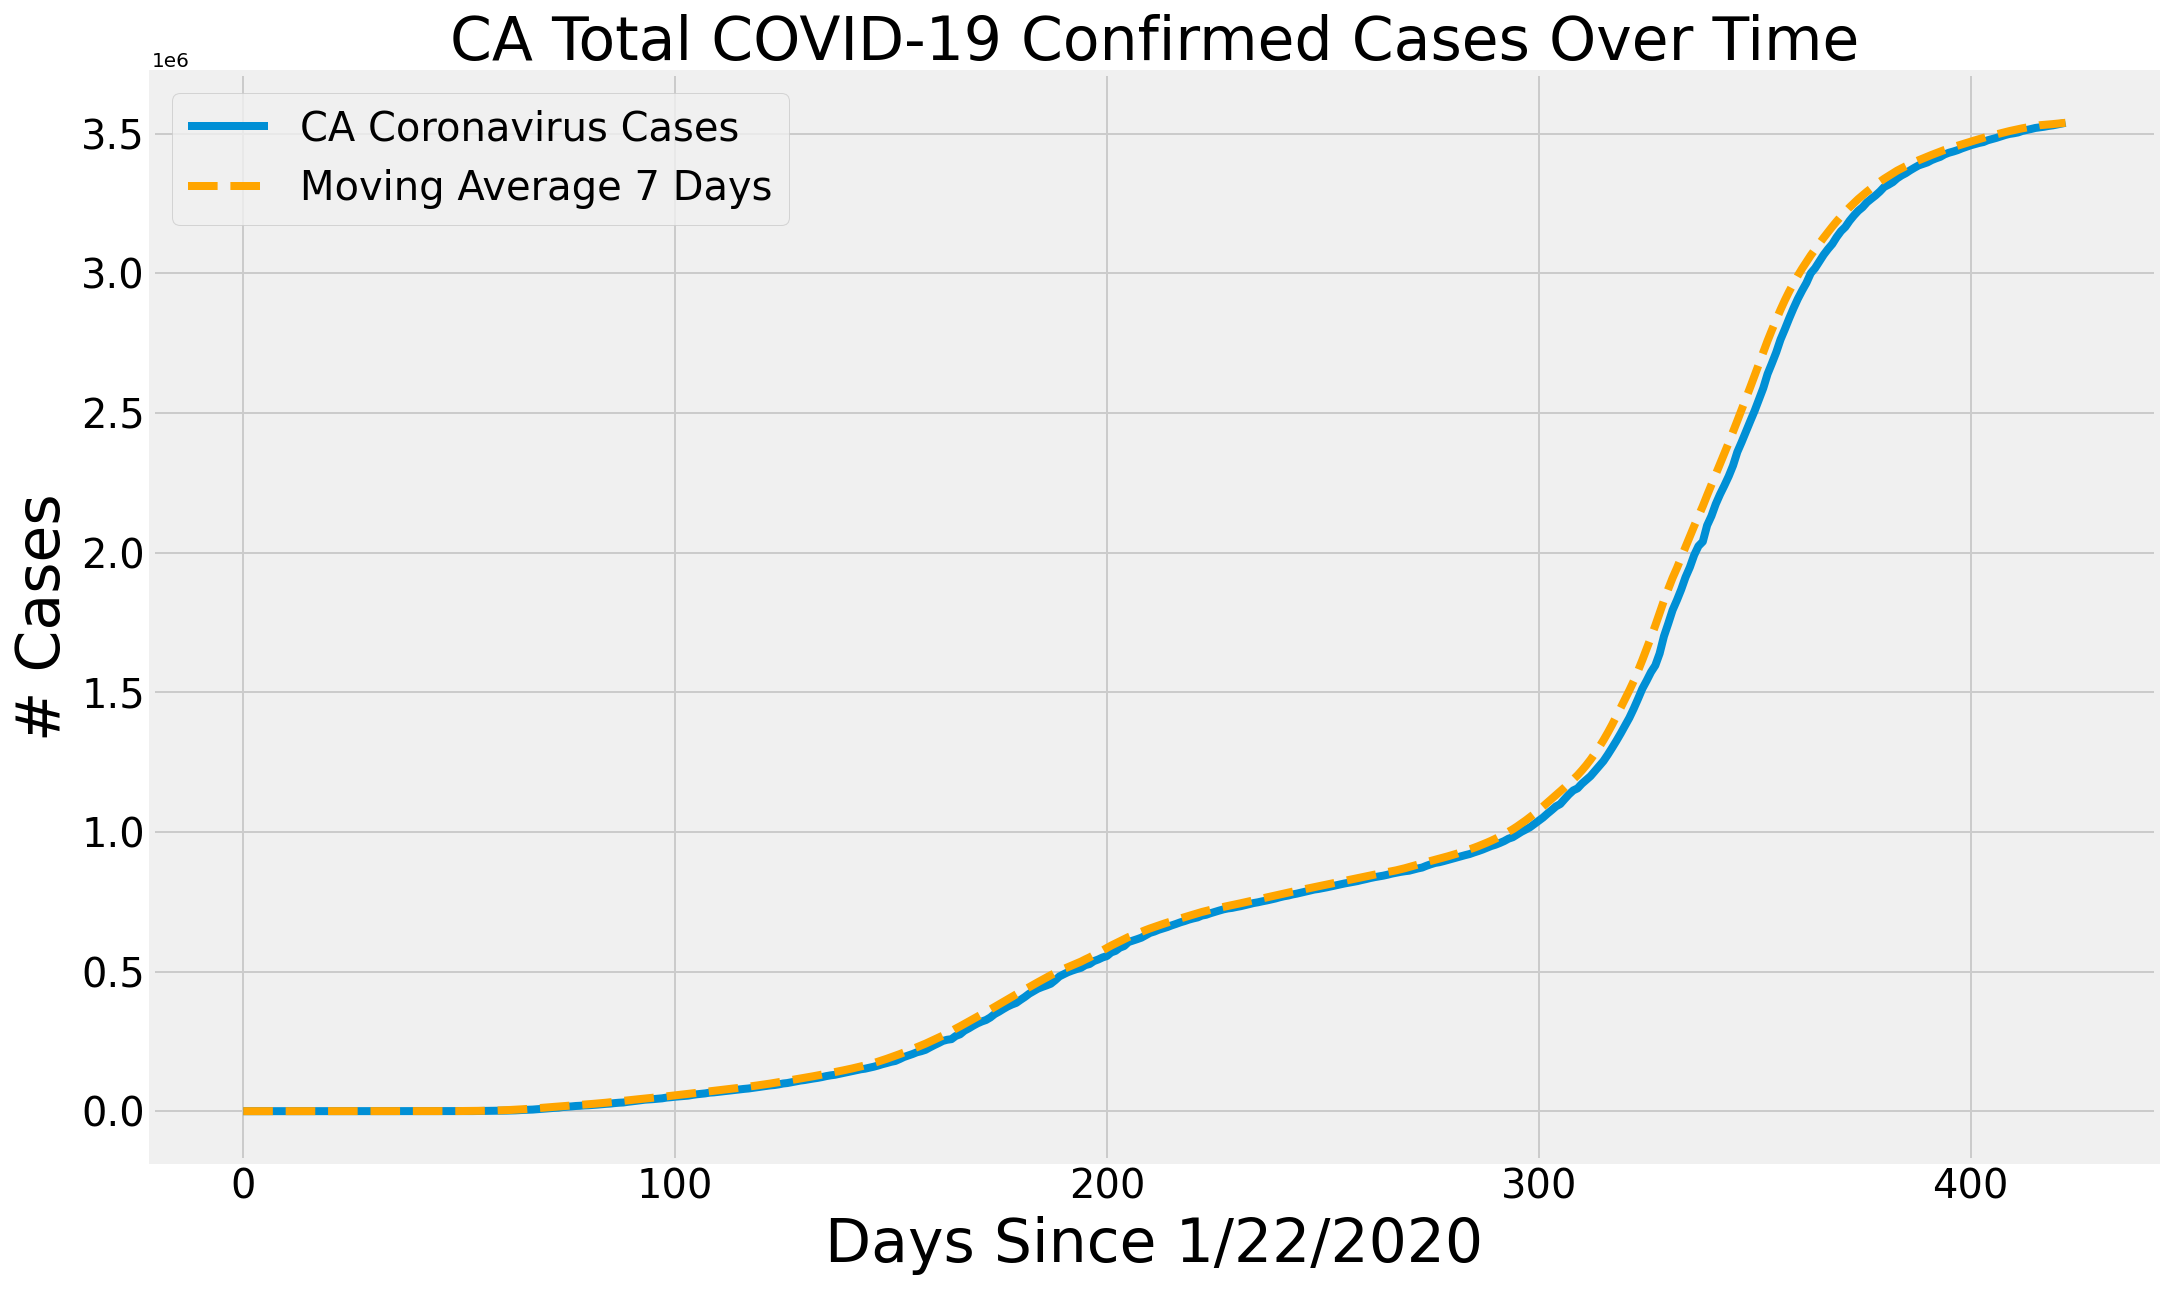

In [13]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_cases)
plt.plot(adjusted_dates, total_case_avg, linestyle='dashed', color='orange')
plt.title('CA Total COVID-19 Confirmed Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# Cases', size=30)
plt.legend(['CA Coronavirus Cases', 'Moving Average {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


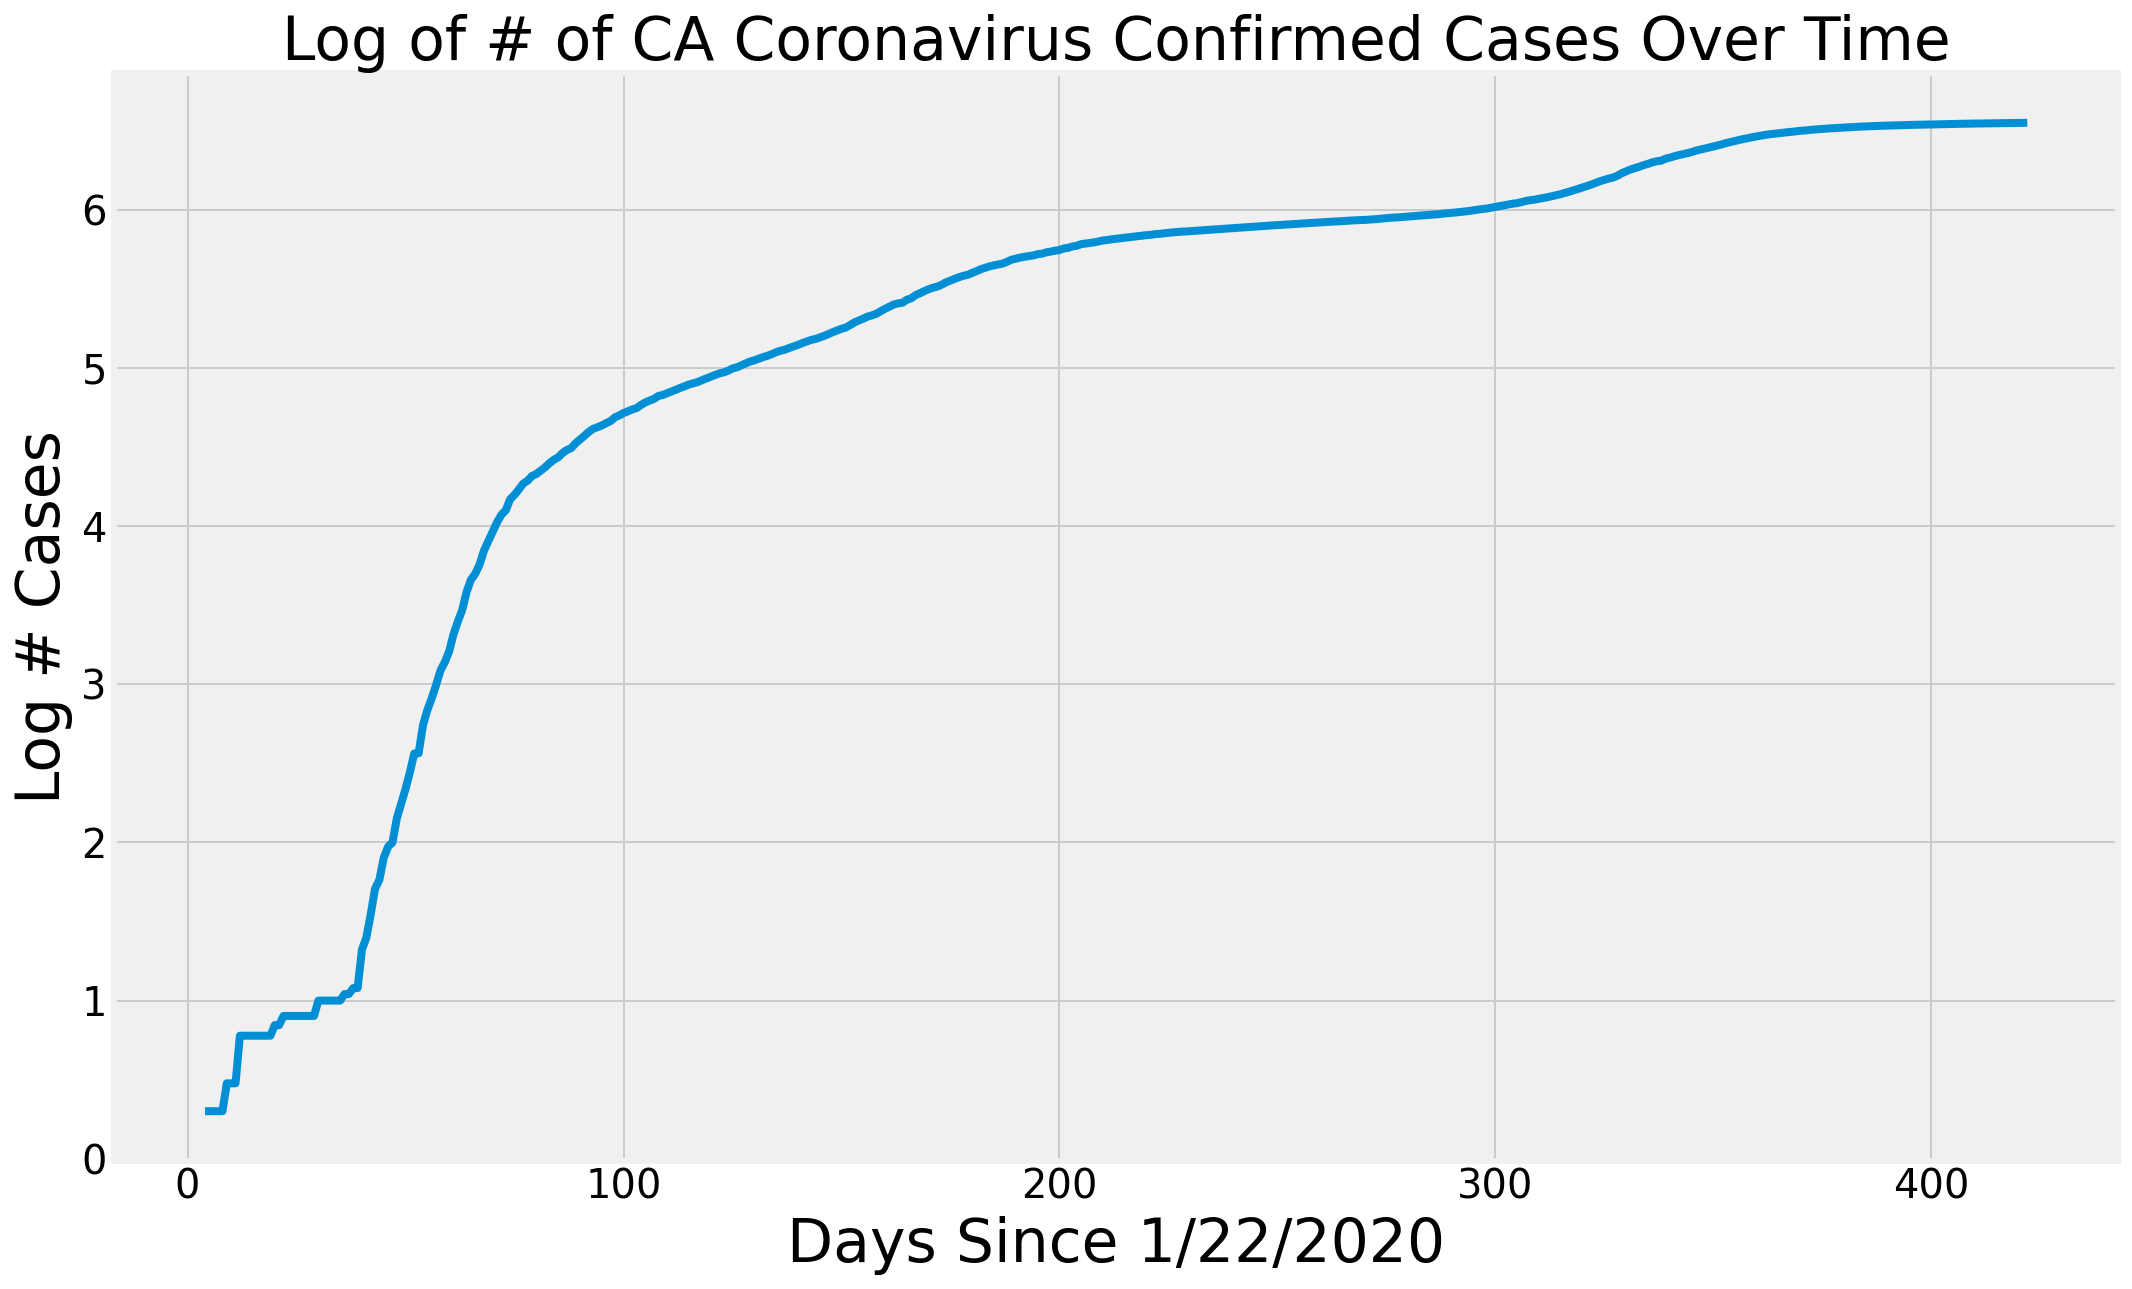

In [14]:
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, np.log10(total_cases))
plt.title('Log of # of CA Coronavirus Confirmed Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Log # Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


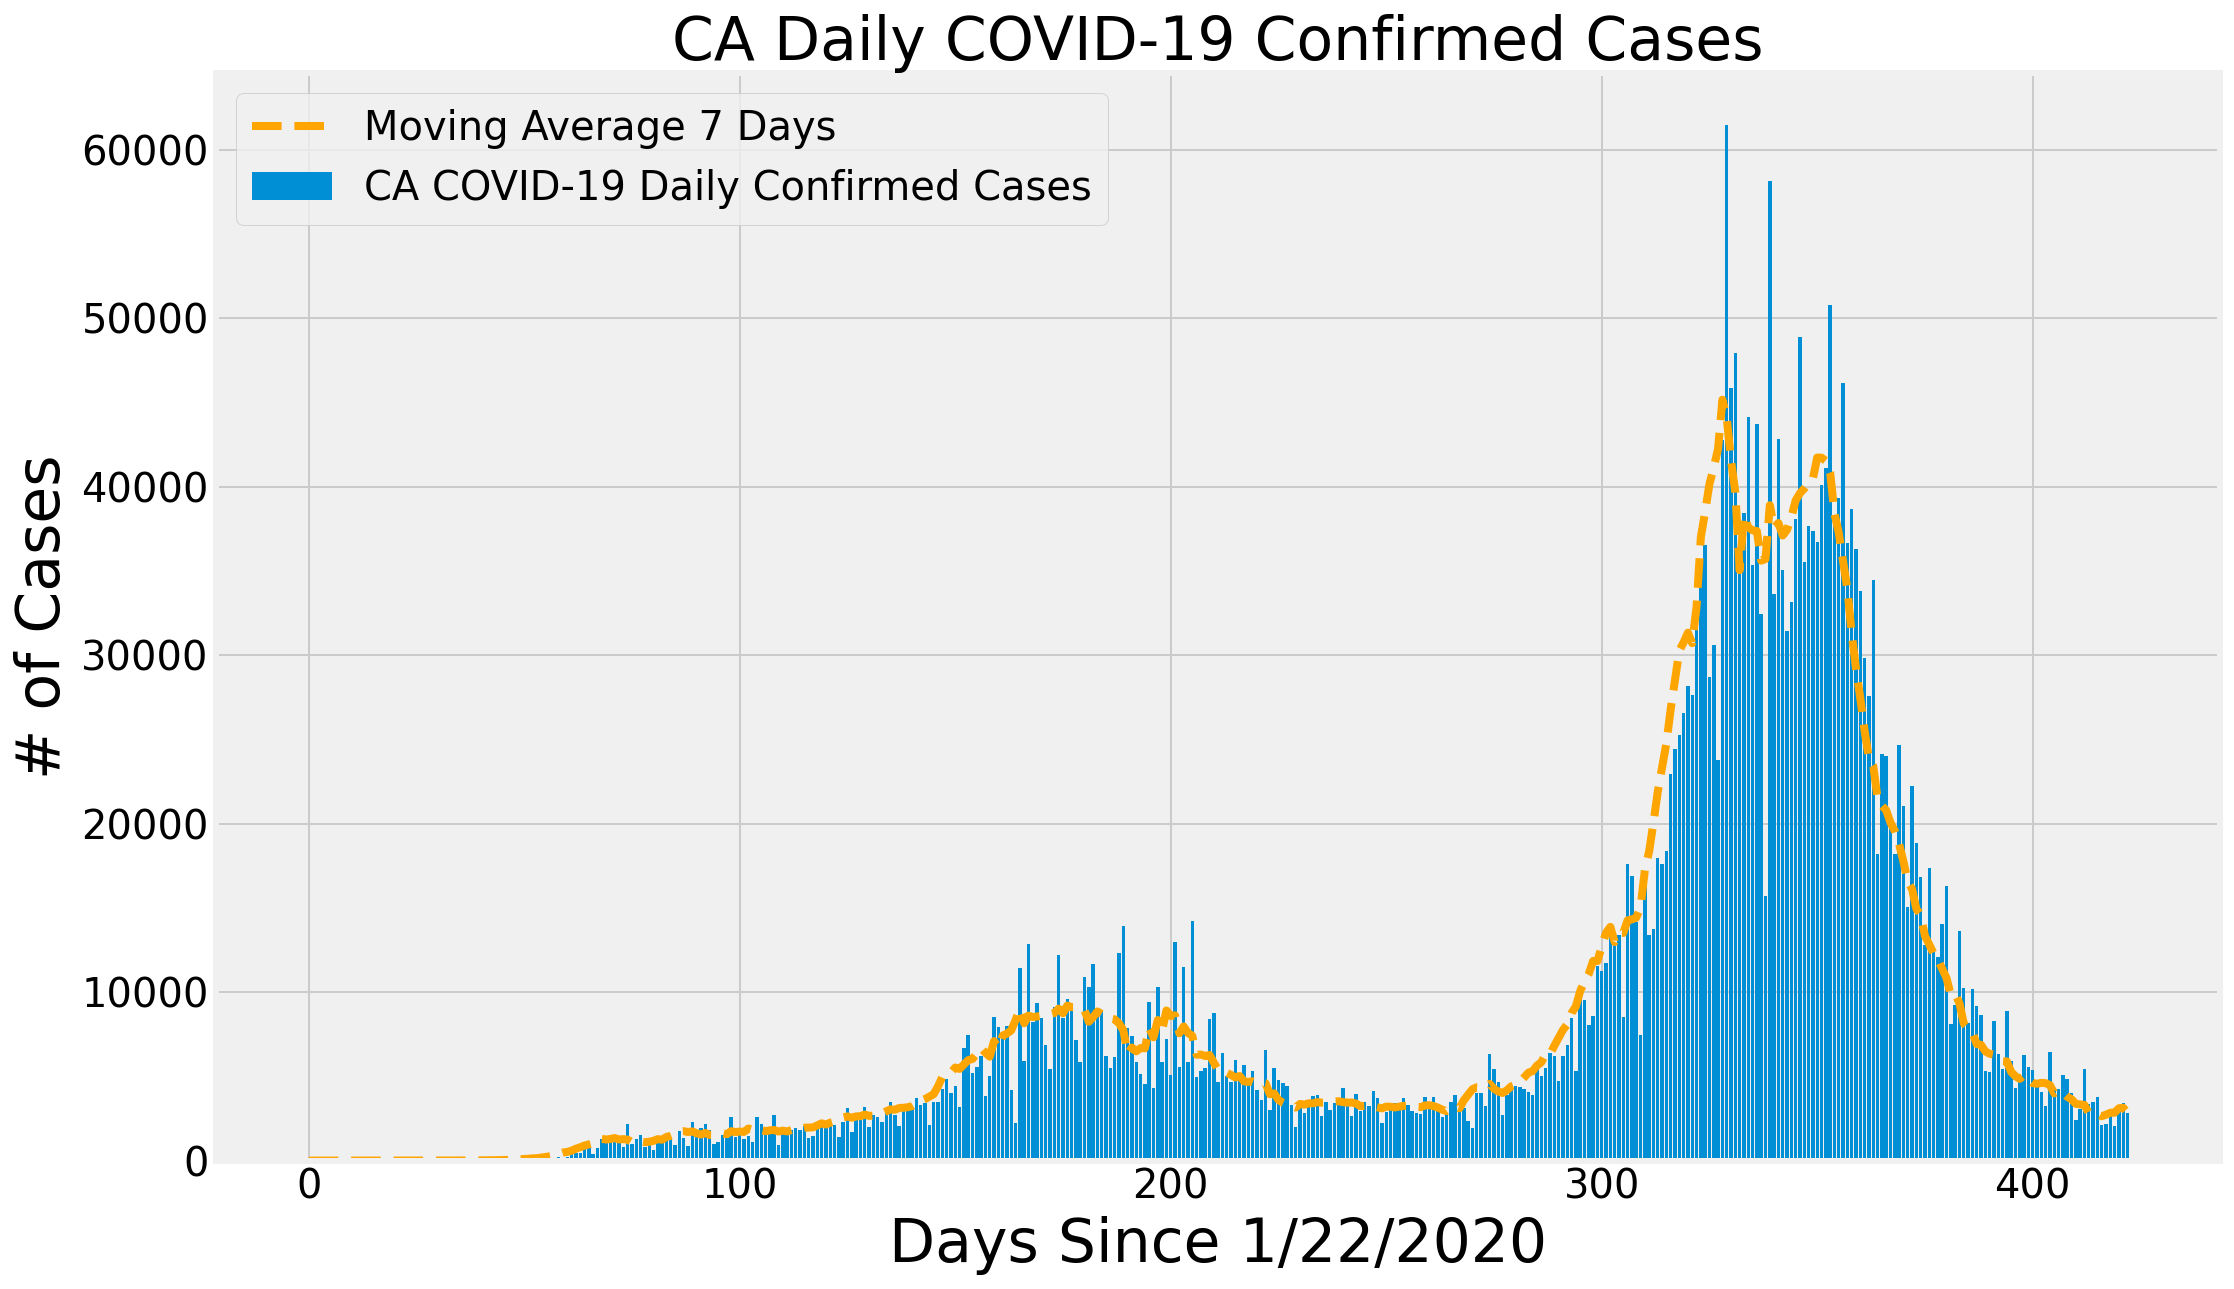

In [15]:
plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, daily_cases)
plt.plot(adjusted_dates, daily_case_avg, color='orange', linestyle='dashed')
plt.title('CA Daily COVID-19 Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'CA COVID-19 Daily Confirmed Cases'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


# 1. Total Confirmed Cases Prediction- SVM

In [16]:
# slightly modify the data to fit the model better (regression models cannot pick the pattern)
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[50:], total_cases[50:], test_size=0.2, shuffle=False)

In [ ]:
# # use this to find the optimal parameters for SVR
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]

svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR(kernel='poly', degree=3)
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
svm_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
svm_search.best_params_

In [ ]:
svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

In [ ]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

# 2. Total Confirmed Cases Prediction- Polynomial Regression

In [17]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=4)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=5)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

In [18]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 1490166.8025331008
MSE: 4209049581531.7134


In [19]:
print(linear_model.coef_)

[[ 1.68471362e+06 -5.18128315e+04  5.16309407e+02 -1.95195015e+00
   2.61910337e-03]]


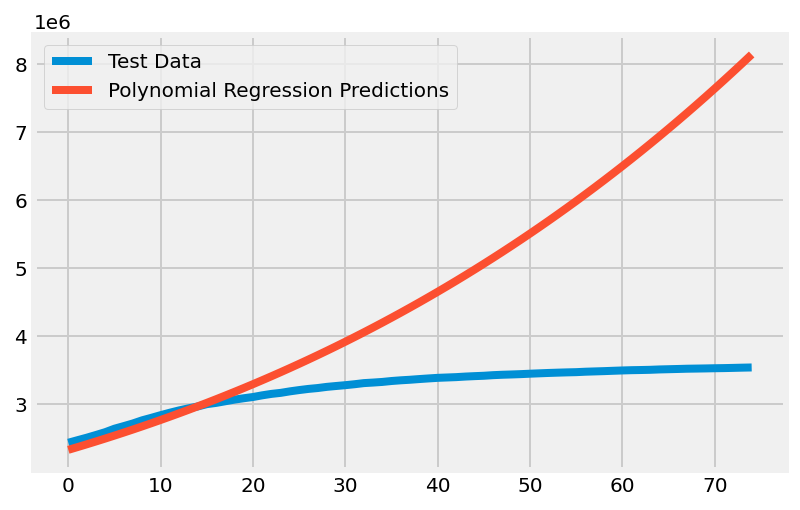

In [20]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

# 3. Total Confirmed Cases Prediction- Bayesian Ridge Polynomial Regression 

In [21]:
# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    3.2s finished


RandomizedSearchCV(cv=3, estimator=BayesianRidge(fit_intercept=False),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'lambda_2': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'normalize': [True, False],
                                        'tol': [1e-06, 1e-05, 0.0001, 0.001,
                                                0.01]},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [22]:
bayesian_search.best_params_

{'tol': 1e-06,
 'normalize': True,
 'lambda_2': 1e-06,
 'lambda_1': 0.001,
 'alpha_2': 1e-06,
 'alpha_1': 0.0001}

In [23]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 987447.4448142381
MSE: 1907984750649.809


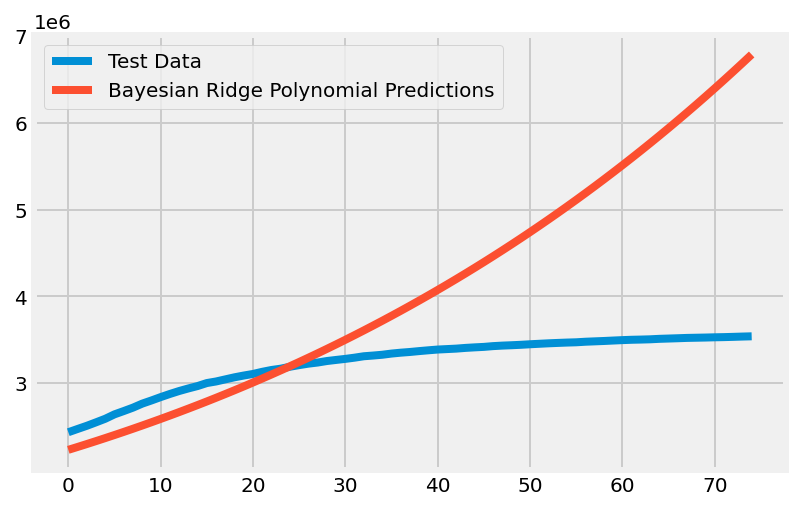

In [23]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

In [24]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 10))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('CA Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

In [ ]:
plot_predictions(adjusted_dates, total_cases, svm_pred, 'SVM Predictions', 'purple')

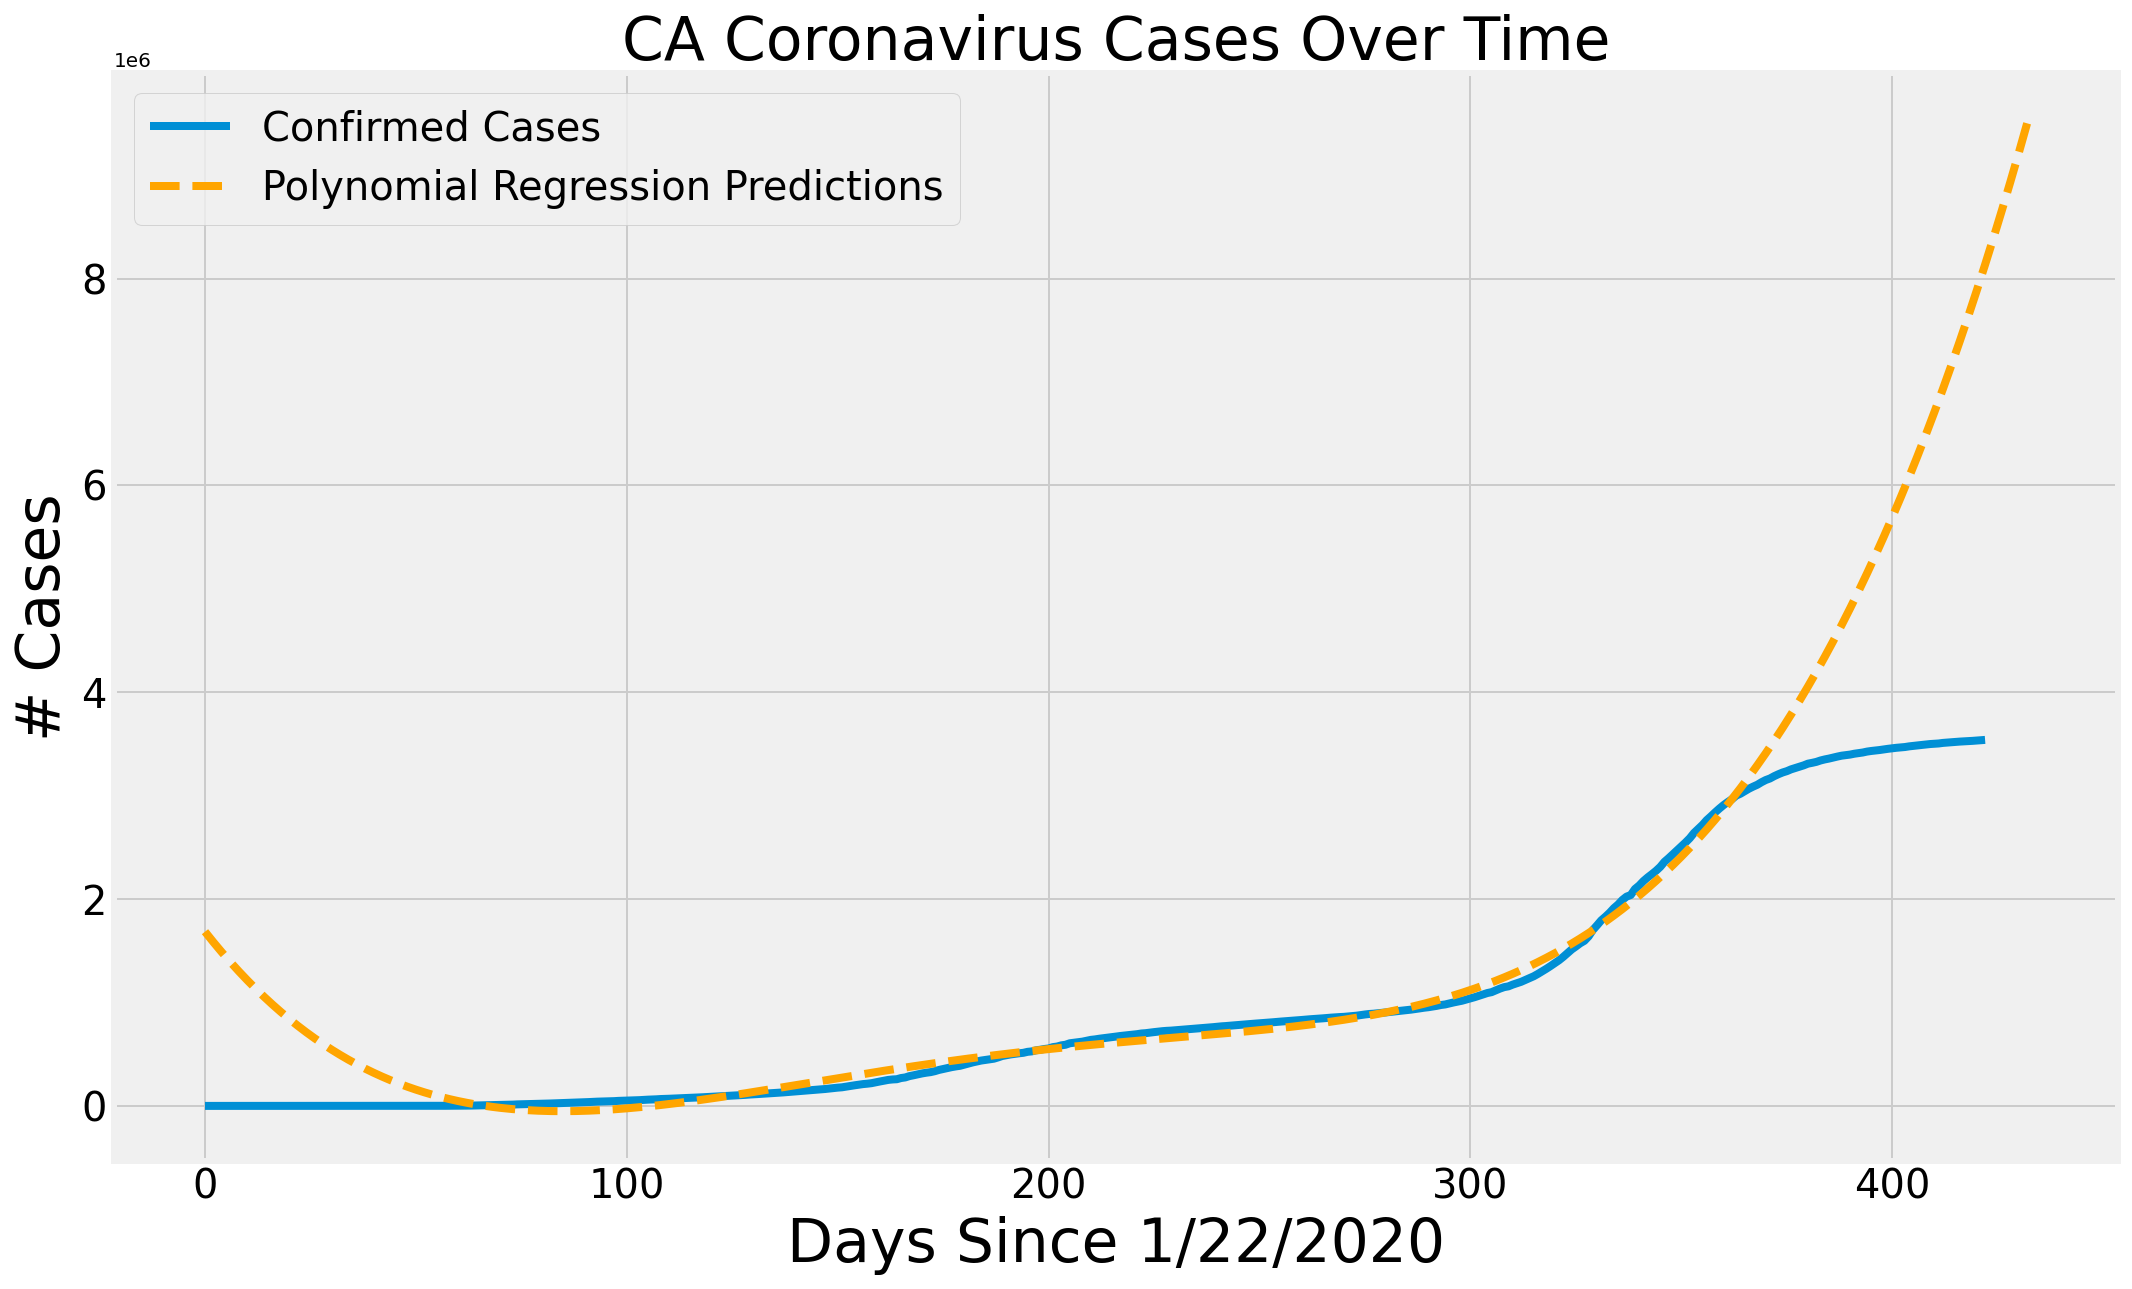

In [25]:
plot_predictions(adjusted_dates, total_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')

In [ ]:
plot_predictions(adjusted_dates, total_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')

In [37]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
svm_df.style.background_gradient(cmap='Reds')

,Date,SVM Predicted # of Confirmed Cases Worldwide
0,03/20/2021,151811170.000000
1,03/21/2021,152876054.000000
2,03/22/2021,153945972.000000
3,03/23/2021,155020937.000000
4,03/24/2021,156100960.000000
5,03/25/2021,157186054.000000
6,03/26/2021,158276231.000000
7,03/27/2021,159371502.000000
8,03/28/2021,160471879.000000
9,03/29/2021,161577374.000000


In [26]:
# Future predictions using polynomial regression
linear_pred = linear_pred.reshape(1,-1)[0]
linear_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of CA Confirmed Cases': np.round(linear_pred[-10:])})
linear_df.style.background_gradient(cmap='Reds')

,Date,Polynomial Predicted # of CA Confirmed Cases
0,03/21/2022,8265557.000000
1,03/22/2022,8396542.000000
2,03/23/2022,8529244.000000
3,03/24/2022,8663678.000000
4,03/25/2022,8799860.000000
5,03/26/2022,8937803.000000
6,03/27/2022,9077524.000000
7,03/28/2022,9219037.000000
8,03/29/2022,9362358.000000
9,03/30/2022,9507503.000000


In [27]:
# Future predictions using Bayesian Ridge 
bayesian_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Bayesian Ridge Predicted # of CA Confirmed Cases': np.round(bayesian_pred[-10:])})
bayesian_df.style.background_gradient(cmap='Reds')

,Date,Bayesian Ridge Predicted # of CA Confirmed Cases
0,03/21/2022,6888538.000000
1,03/22/2022,6990700.000000
2,03/23/2022,7094232.000000
3,03/24/2022,7199149.000000
4,03/25/2022,7305464.000000
5,03/26/2022,7413192.000000
6,03/27/2022,7522348.000000
7,03/28/2022,7632944.000000
8,03/29/2022,7744997.000000
9,03/30/2022,7858520.000000


# 4. Daily Confirmed Cases Prediction- ARIMA

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Let's load the libraries and dependencies for the deep learning model
from sklearn.preprocessing import MinMaxScaler

#%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

In [7]:
confirmed_df = pd.read_csv('time_series_covid19_confirmed_CA_Transposed.csv')
confirmed_df = confirmed_df.dropna()
confirmed_df

,Date,84006001,84006003,84006005,84006007,84006009,84006011,84006013,84006015,84006017,...,84006103,84006105,84006107,84006109,84090006,84006111,84006113,84006115,SUM,Daily
0,1/22/2020,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1/23/2020,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1/24/2020,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1/25/2020,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1/26/2020,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,6/30/2021,90276,89,3754,12669,2214,2298,71150,1481,10440,...,5751,428,49823,4236,35,81884,14171,6538,3816659,1644
526,7/1/2021,90281,89,3756,12676,2217,2298,71319,1485,10467,...,5757,428,49896,4243,23,81884,14178,6545,3818326,1667
527,7/2/2021,90460,89,3758,12684,2220,2298,71399,1487,10479,...,5758,428,49896,4244,21,81947,14188,6555,3819662,1336
528,7/3/2021,90460,89,3758,12684,2220,2298,71478,1487,10479,...,5762,428,49896,4244,21,81947,14188,6555,3820442,780


In [8]:
confirmed_df.index = pd.to_datetime(confirmed_df['Date'])
confirmed_df.tail()

,Date,84006001,84006003,84006005,84006007,84006009,84006011,84006013,84006015,84006017,...,84006103,84006105,84006107,84006109,84090006,84006111,84006113,84006115,SUM,Daily
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-30,6/30/2021,90276,89,3754,12669,2214,2298,71150,1481,10440,...,5751,428,49823,4236,35,81884,14171,6538,3816659,1644
2021-07-01,7/1/2021,90281,89,3756,12676,2217,2298,71319,1485,10467,...,5757,428,49896,4243,23,81884,14178,6545,3818326,1667
2021-07-02,7/2/2021,90460,89,3758,12684,2220,2298,71399,1487,10479,...,5758,428,49896,4244,21,81947,14188,6555,3819662,1336
2021-07-03,7/3/2021,90460,89,3758,12684,2220,2298,71478,1487,10479,...,5762,428,49896,4244,21,81947,14188,6555,3820442,780
2021-07-04,7/4/2021,90375,89,3758,12684,2220,2298,71548,1487,10479,...,5762,428,49896,4244,21,81947,14188,6555,3820921,479


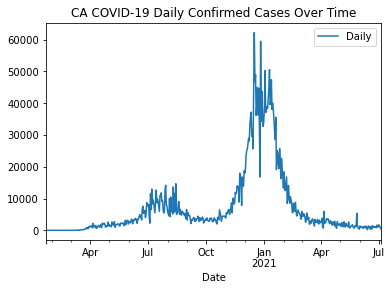

In [9]:
dr = confirmed_df[['Daily']]
dr.plot()
plt.title('CA COVID-19 Daily Confirmed Cases Over Time');

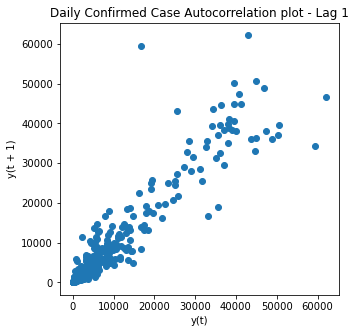

In [10]:
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(confirmed_df['Daily'], lag=1)
plt.title('Daily Confirmed Case Autocorrelation plot - Lag 1');


# Build Train-Test Datasets- Daily Cases

In [12]:
train_data, test_data = confirmed_df.iloc[0:int(len(confirmed_df)*0.8), :], confirmed_df.iloc[int(len(confirmed_df)*0.8):, :]

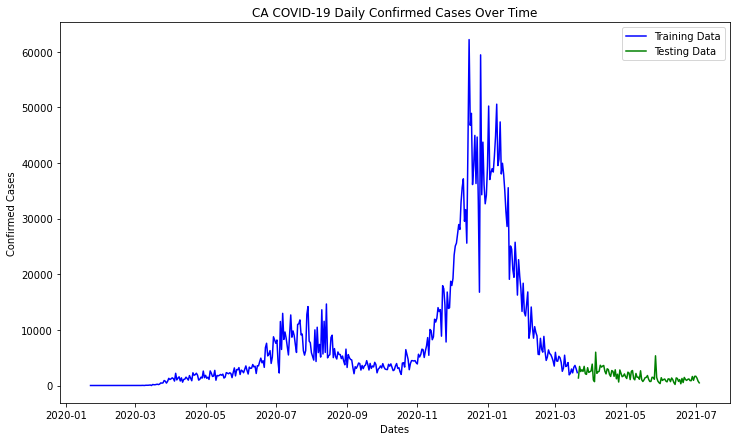

In [13]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(train_data['Daily'], 'blue', label='Training Data')
plt.plot(test_data['Daily'], 'green', label='Testing Data')
plt.legend();

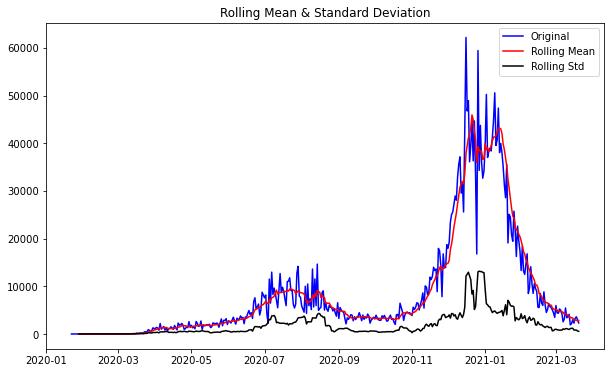

In [14]:
window = 7
train_series = train_data['Daily']

#Determing rolling statistics
rolmean = train_series.rolling(window).mean()
rolstd = train_series.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

In [15]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(train_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -2.272212
p-value                          0.181087
#Lags Used                      17.000000
Number of Observations Used    406.000000
Critical Value (1%)             -3.446560
Critical Value (5%)             -2.868685
Critical Value (10%)            -2.570576
dtype: float64

# Apply a first order differencing on the training data

In [16]:
train_diff = train_series.diff()
train_diff = train_diff.dropna(inplace = False)

In [17]:
train_diff

Date
2020-01-23      0.0
2020-01-24      0.0
2020-01-25      0.0
2020-01-26      2.0
2020-01-27     -2.0
              ...  
2021-03-16   -691.0
2021-03-17    999.0
2021-03-18    335.0
2021-03-19   -574.0
2021-03-20   -721.0
Name: Daily, Length: 423, dtype: float64

# Visualize Rolling statistics for differenced train data

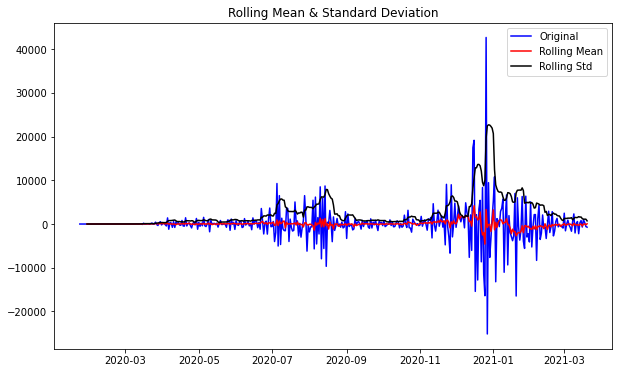

In [18]:
#Determing rolling statistics
rolmean = train_diff.rolling(window).mean()
rolstd = train_diff.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

# Compute AD-Fuller Stats for differenced train data

In [19]:
dftest = adfuller(train_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -3.433080
p-value                          0.009882
#Lags Used                      16.000000
Number of Observations Used    406.000000
Critical Value (1%)             -3.446560
Critical Value (5%)             -2.868685
Critical Value (10%)            -2.570576
dtype: float64

# Plot ACF and PACF on the original train series

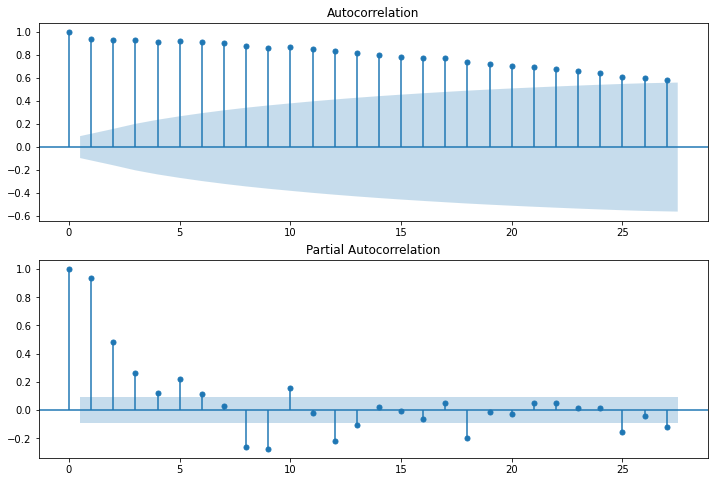

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_series, ax=ax[0]); # 
plot_pacf(train_series, ax=ax[1]);

# Plot ACF and PACF on the differenced train series

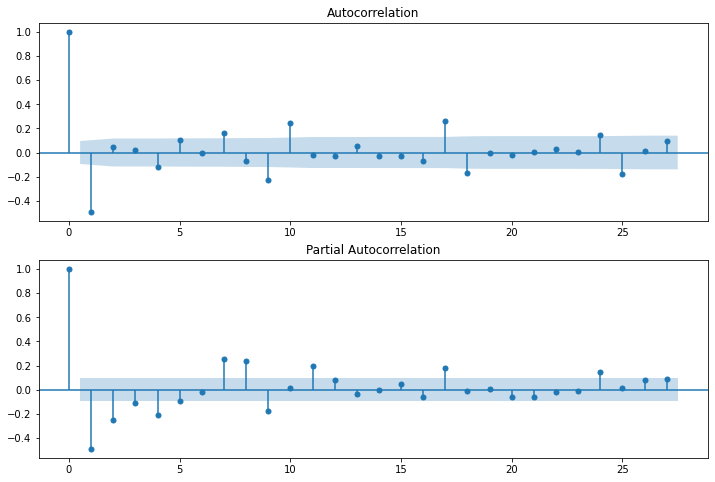

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_diff, ax=ax[0]); # 
plot_pacf(train_diff, ax=ax[1]);

# Evaluation of ARIMA Model

In [22]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

# Difference the Test Series

In [23]:
test_series = test_data['Daily']
test_diff = test_series.diff()
test_diff = test_diff.dropna(inplace = False)
test_diff

Date
2021-03-22    2075.0
2021-03-23    -922.0
2021-03-24     325.0
2021-03-25    -300.0
2021-03-26     912.0
               ...  
2021-06-30     713.0
2021-07-01      23.0
2021-07-02    -331.0
2021-07-03    -556.0
2021-07-04    -301.0
Name: Daily, Length: 105, dtype: float64

# Train and Forecast using ARIMA Model by filling in the necessary blocks

In [24]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [25]:
%%time 

history = [x for x in train_diff]

predictions = list()
for t in range(len(test_diff)):

    model = ARIMA(history, order=(5,1,0))  # initialize the model with history and right order of parameters
    model_fit = model.fit(disp=0)  # fit the model

    output = model_fit.forecast()  # use forecast on the fitted model
    yhat = output[0][0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

Wall time: 29.4 s


In [26]:
%%time 

history = [x for x in train_diff]

predictions = list()
for t in range(len(test_diff)):

    model = ARIMA(history, order=(5,1,0))  # initialize the model with history and right order of parameters
    model_fit = model.fit(disp=0)  # fit the model
   
    output = model_fit.forecast()  # use forecast on the fitted model
    yhat = output[0][0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

Test Series Point: 0	Predicted=531.9576450719903, Expected=2075.0
Test Series Point: 100	Predicted=319.15424647606596, Expected=713.0
Wall time: 29.8 s


# Reverse Transform the forecasted values

In [27]:
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((106,), (106,))

# Evaluate model performance

In [28]:
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(reverse_test_diff, reverse_predictions)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 999188.746
Symmetric Mean absolute percentage error: 50.051


In [30]:
reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_series.index

reverse_predictions_series = pd.Series(reverse_test_diff)
reverse_predictions_series.index = test_series.index

# Visualize the forecast results

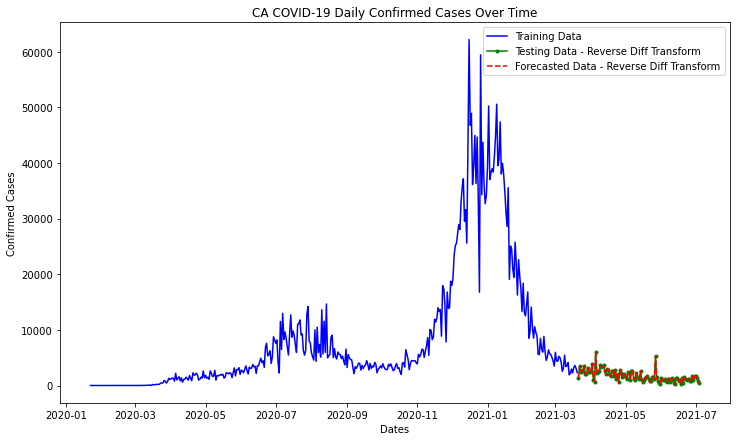

In [31]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(train_series, color='blue', label='Training Data')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Data - Reverse Diff Transform')
plt.plot(reverse_test_diff_series, color='red', linestyle='--', label='Forecasted Data - Reverse Diff Transform')
plt.legend();

# Visualize only test and forecast prices

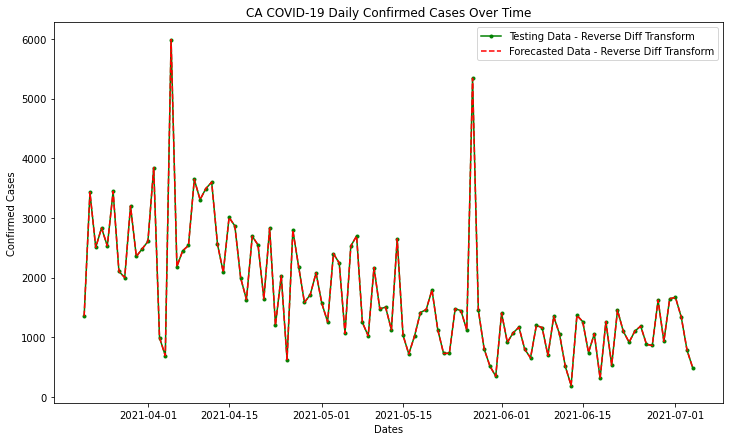

In [32]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Data - Reverse Diff Transform')
plt.plot(reverse_test_diff_series, color='red', linestyle='--', label='Forecasted Data - Reverse Diff Transform')
plt.legend();

# 5. Daily Confirmed Cases Prediction- LSTM

In [33]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [34]:
# Let's load the libraries and dependencies for the deep learning model
from sklearn.preprocessing import MinMaxScaler

#%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

In [35]:
confirmed_df = pd.read_csv("time_series_covid19_confirmed_CA_Transposed.csv")
confirmed_df.isnull().values.any()
confirmed_df = confirmed_df.dropna()

confirmed_df.index = pd.to_datetime(confirmed_df['Date'])
confirmed_df.tail()

,Date,84006001,84006003,84006005,84006007,84006009,84006011,84006013,84006015,84006017,...,84006103,84006105,84006107,84006109,84090006,84006111,84006113,84006115,SUM,Daily
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-30,6/30/2021,90276,89,3754,12669,2214,2298,71150,1481,10440,...,5751,428,49823,4236,35,81884,14171,6538,3816659,1644
2021-07-01,7/1/2021,90281,89,3756,12676,2217,2298,71319,1485,10467,...,5757,428,49896,4243,23,81884,14178,6545,3818326,1667
2021-07-02,7/2/2021,90460,89,3758,12684,2220,2298,71399,1487,10479,...,5758,428,49896,4244,21,81947,14188,6555,3819662,1336
2021-07-03,7/3/2021,90460,89,3758,12684,2220,2298,71478,1487,10479,...,5762,428,49896,4244,21,81947,14188,6555,3820442,780
2021-07-04,7/4/2021,90375,89,3758,12684,2220,2298,71548,1487,10479,...,5762,428,49896,4244,21,81947,14188,6555,3820921,479


# Build Train-Test Datasets- Daily Cases

In [36]:
# Splitting the train and test set considering 'Open' feature from the dataset
train_data, test_data = confirmed_df.iloc[0:int(len(confirmed_df)*0.8), :], confirmed_df.iloc[int(len(confirmed_df)*0.8):, :]
train_series = train_data['Daily']
test_series = test_data['Daily']
train_series.shape, test_series.shape

((424,), (106,))

# Visualize train and test data

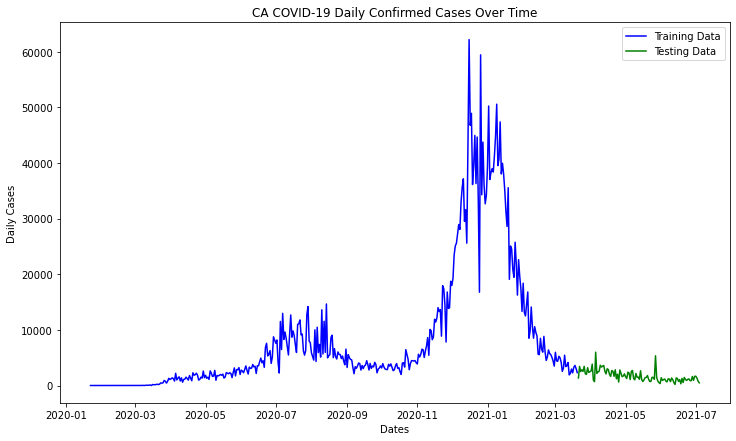

In [37]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Daily Cases')
plt.plot(train_data['Daily'], 'blue', label='Training Data')
plt.plot(test_data['Daily'], 'green', label='Testing Data')
plt.legend();

# Scaling

In [38]:
sc = MinMaxScaler(feature_range=(0,1))

training_set_scaled = sc.fit_transform(train_series.values.reshape(-1,1))
training_set_scaled

array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [3.21708918e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.60854459e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       [4.82563377e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.60854459e-05],
       [0.00000000e+00],
       [1.60854459e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [3.21708918e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.60854459e-05],
       [0.00000000e+00],
       [1.60854459e-05],
       [0.00000000e+00],


In [39]:
training_set_scaled.shape

(424, 1)

# Train Data Preparation

In [40]:
#1 output and 60 values inputs
# So for each element of training set (output), we have 60 previous training set elements (input)

X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((364, 60), (364,))

In [41]:
# Reshaping X_train for efficient modeling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))

In [42]:
X_train.shape

(364, 60, 1)

# Build the LSTM based forecasting DL Model architecture

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
import time #helper libraries

In [44]:
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(1))

# Compiling the RNN - optimizer(rmsprop)and loss(mean squared error)
regressor.compile(loss='mse', optimizer='rmsprop')

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 64)            16896     
_________________________________________________________________
dropout (Dropout)            (None, 60, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [45]:
regressor.fit(X_train,y_train, epochs=15, batch_size=64, validation_split=0.1, shuffle=False)

Epoch 1/15
6/6 [==============================] - 27s 338ms/step - loss: 0.0051 - val_loss: 8.6124e-04
Epoch 2/15
6/6 [==============================] - 0s 60ms/step - loss: 0.0085 - val_loss: 0.0029
Epoch 3/15
6/6 [==============================] - 0s 63ms/step - loss: 0.0068 - val_loss: 0.0014
Epoch 4/15
6/6 [==============================] - 0s 69ms/step - loss: 0.0048 - val_loss: 0.0016
Epoch 5/15
6/6 [==============================] - 0s 60ms/step - loss: 0.0039 - val_loss: 4.2275e-04
Epoch 6/15
6/6 [==============================] - 0s 59ms/step - loss: 0.0030 - val_loss: 3.3379e-04
Epoch 7/15
6/6 [==============================] - 0s 60ms/step - loss: 0.0028 - val_loss: 4.7522e-04
Epoch 8/15
6/6 [==============================] - 0s 58ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 9/15
6/6 [==============================] - 0s 60ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 10/15
6/6 [==============================] - 0s 62ms/step - loss: 0.0035 - val_loss: 3.8372e-04
Epoch 1

# Test Data Forecasting

# Get the last 60 records from train_series

In [46]:
train_last60 = train_series[-60:]
print(train_last60.shape)
assert train_last60.shape == (60,), ("Oops! There is a data dimension mismatch error. Hint: Slice the last 60 records from train_series")

(60,)


In [47]:
test_series.shape

(106,)

In [48]:
print(test_series)

Date
2021-03-21    1352
2021-03-22    3427
2021-03-23    2505
2021-03-24    2830
2021-03-25    2530
              ... 
2021-06-30    1644
2021-07-01    1667
2021-07-02    1336
2021-07-03     780
2021-07-04     479
Name: Daily, Length: 106, dtype: int64


# Combine both train_last60 and test_series together

In [49]:
new_test_series =  pd.concat([train_last60, test_series], axis=0)
print(new_test_series.shape)
#assert new_test_series.shape == (664,), ("Oops! There is a data dimension mismatch error. Hint: Use pandas concat with the right axis parameter")

(166,)


# Scale the test dataset using the trained MinMaxScaler transformer - sc

In [50]:
test_set_scaled = sc.transform(new_test_series.values.reshape(-1, 1))

# Prepare Test dataset Windows of 60 days each

In [51]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(test_set_scaled)):
    X_test.append(test_set_scaled[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(106, 60, 1)

# Model Prediction and Reverse Transform

In [52]:
predicted_confirmed_cases = regressor.predict(X_test)
predicted_confirmed_cases_revtrans = sc.inverse_transform(predicted_confirmed_cases).ravel()
predicted_confirmed_cases_revtrans_series = pd.Series(predicted_confirmed_cases_revtrans)
predicted_confirmed_cases_revtrans_series.index = test_series.index
predicted_confirmed_cases_revtrans_series.shape, test_series.shape

((106,), (106,))

# Model Evaluation

In [53]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

In [54]:
error = mean_squared_error(test_series, predicted_confirmed_cases_revtrans_series)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_series, predicted_confirmed_cases_revtrans_series)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 3722344.572
Symmetric Mean absolute percentage error: 77.743


# Visualizing the results from model predictions

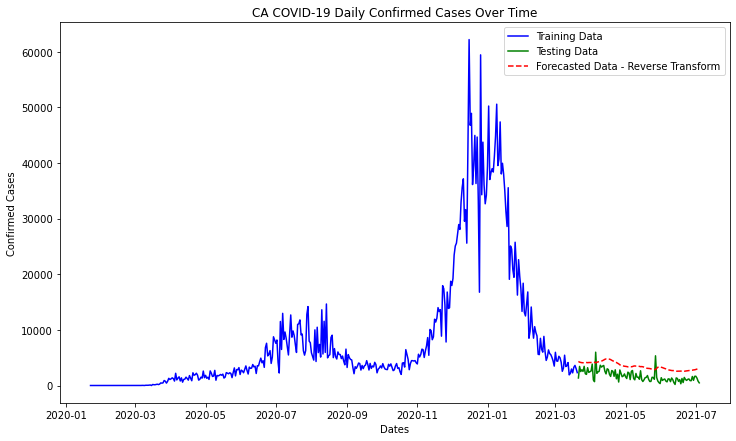

In [55]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(train_series, color='blue', label='Training Data')
plt.plot(test_series, color='green', label='Testing Data')
plt.plot(predicted_confirmed_cases_revtrans_series, color='red', linestyle='--', label='Forecasted Data - Reverse Transform')
plt.legend();

# Visualize only test and forecast data

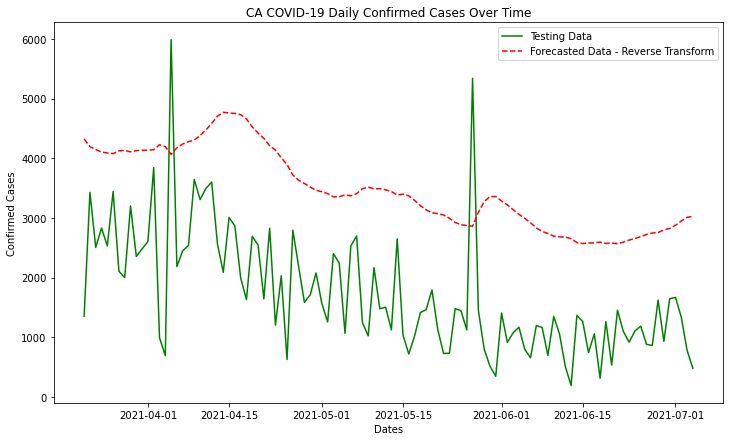

In [56]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(test_series, color='green', label='Testing Data')
plt.plot(predicted_confirmed_cases_revtrans_series, color='red', linestyle='--', label='Forecasted Data - Reverse Transform')
plt.legend();

# 6. Total Confirmed Cases Prediction- LSTM

In [25]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [26]:
# Let's load the libraries and dependencies for the deep learning model
from sklearn.preprocessing import MinMaxScaler

#%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

In [27]:
confirmed_df = pd.read_csv("time_series_covid19_confirmed_CA_Transposed.csv")
confirmed_df.isnull().values.any()
confirmed_df = confirmed_df.dropna()

confirmed_df.index = pd.to_datetime(confirmed_df['Date'])
confirmed_df.tail()

,Date,84006001,84006003,84006005,84006007,84006009,84006011,84006013,84006015,84006017,...,84006097,84006099,84006101,84006103,84006105,84006107,84006109,84090006,SUM,Daily
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-15,3/15/2021,82116,85,3504,11140,1946,2155,64096,1068,9296,...,28798,57621,8996,5160,378,48604,3994,0,3528233,2824
2021-03-16,3/16/2021,82168,85,3506,11141,1951,2155,64203,1069,9305,...,28820,57687,9006,5180,378,48649,3995,0,3530281,2048
2021-03-17,3/17/2021,82258,85,3506,11141,1958,2155,64280,1078,9313,...,28845,57817,9020,5180,380,48691,4003,0,3533329,3048
2021-03-18,3/18/2021,82368,86,3506,11141,1963,2155,64358,1090,9326,...,28882,57904,9029,5180,381,48740,4006,0,3536748,3419
2021-03-19,3/19/2021,82460,86,3506,11141,1968,2156,64454,1095,9340,...,28914,58019,9042,5213,384,48770,4008,0,3539602,2854


# Build Train-Test Datasets- Total Cases

In [57]:
# Splitting the train and test set considering 'Open' feature from the dataset
train_data, test_data = confirmed_df.iloc[0:int(len(confirmed_df)*0.8), :], confirmed_df.iloc[int(len(confirmed_df)*0.8):, :]
train_series = train_data['SUM']
test_series = test_data['SUM']
train_series.shape, test_series.shape

((424,), (106,))

# Visualize train and test data

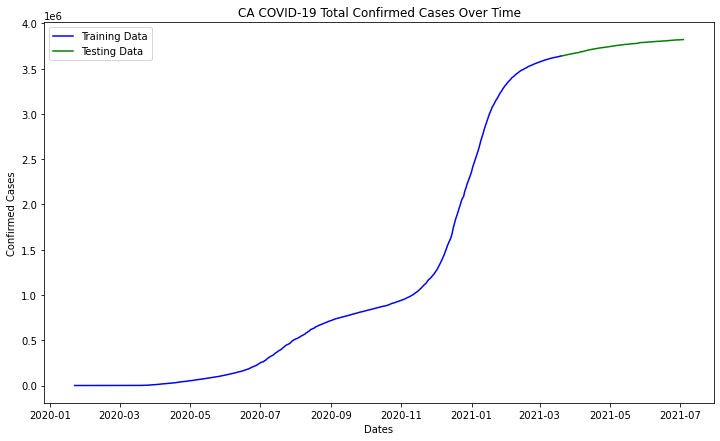

In [58]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Total Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(train_data['SUM'], 'blue', label='Training Data')
plt.plot(test_data['SUM'], 'green', label='Testing Data')
plt.legend();

# Scaling

In [59]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(train_series.values.reshape(-1,1))
training_set_scaled

array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [5.49371464e-07],
       [5.49371464e-07],
       [5.49371464e-07],
       [5.49371464e-07],
       [5.49371464e-07],
       [8.24057196e-07],
       [8.24057196e-07],
       [8.24057196e-07],
       [1.64811439e-06],
       [1.64811439e-06],
       [1.64811439e-06],
       [1.64811439e-06],
       [1.64811439e-06],
       [1.64811439e-06],
       [1.64811439e-06],
       [1.64811439e-06],
       [1.92280012e-06],
       [1.92280012e-06],
       [2.19748586e-06],
       [2.19748586e-06],
       [2.19748586e-06],
       [2.19748586e-06],
       [2.19748586e-06],
       [2.19748586e-06],
       [2.19748586e-06],
       [2.19748586e-06],
       [2.74685732e-06],
       [2.74685732e-06],
       [2.74685732e-06],
       [2.74685732e-06],
       [2.74685732e-06],
       [2.74685732e-06],
       [3.02154305e-06],
       [3.02154305e-06],
       [3.29622878e-06],
       [3.29622878e-06],


In [60]:
training_set_scaled.shape

(424, 1)

# Train Data Preparation

In [61]:
#1 output and 60 values inputs
# So for each element of training set (output), we have 60 previous training set elements (input)

X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((364, 60), (364,))

In [62]:
# Reshaping X_train for efficient modeling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))

In [63]:
X_train.shape

(364, 60, 1)

# Build the LSTM based forecasting DL Model architecture

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
import time #helper libraries

In [64]:
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(1))

# Compiling the RNN - optimizer(rmsprop)and loss(mean squared error)
regressor.compile(loss='mse', optimizer='rmsprop')

regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 64)            16896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [65]:
regressor.fit(X_train,y_train, epochs=15, batch_size=64, validation_split=0.1, shuffle=False)

Epoch 1/15
6/6 [==============================] - 7s 300ms/step - loss: 0.0070 - val_loss: 0.0182
Epoch 2/15
6/6 [==============================] - 0s 60ms/step - loss: 0.0099 - val_loss: 0.0926
Epoch 3/15
6/6 [==============================] - 0s 57ms/step - loss: 0.0055 - val_loss: 0.0262
Epoch 4/15
6/6 [==============================] - 0s 60ms/step - loss: 0.0049 - val_loss: 0.0421
Epoch 5/15
6/6 [==============================] - 0s 57ms/step - loss: 0.0047 - val_loss: 0.0630
Epoch 6/15
6/6 [==============================] - 0s 60ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 7/15
6/6 [==============================] - 0s 63ms/step - loss: 0.0057 - val_loss: 0.0576
Epoch 8/15
6/6 [==============================] - 0s 57ms/step - loss: 0.0030 - val_loss: 1.5469e-04
Epoch 9/15
6/6 [==============================] - 0s 66ms/step - loss: 0.0034 - val_loss: 0.0602
Epoch 10/15
6/6 [==============================] - 0s 65ms/step - loss: 0.0032 - val_loss: 1.3368e-04
Epoch 11/15
6/6 [===

# Test Data Forecasting¶

# Get the last 60 records from train_series¶

In [66]:
train_last60 = train_series[-60:]
print(train_last60.shape)
assert train_last60.shape == (60,), ("Oops! There is a data dimension mismatch error. Hint: Slice the last 60 records from train_series")

(60,)


In [67]:
test_series.shape

(106,)

In [68]:
print(test_series)

Date
2021-03-21    3641876
2021-03-22    3645303
2021-03-23    3647808
2021-03-24    3650638
2021-03-25    3653168
               ...   
2021-06-30    3816659
2021-07-01    3818326
2021-07-02    3819662
2021-07-03    3820442
2021-07-04    3820921
Name: SUM, Length: 106, dtype: int64


# Combine both train_last60 and test_series together

In [69]:
new_test_series =  pd.concat([train_last60, test_series], axis=0)
print(new_test_series.shape)
#assert new_test_series.shape == (664,), ("Oops! There is a data dimension mismatch error. Hint: Use pandas concat with the right axis parameter")

(166,)


# Scale the test dataset using the trained MinMaxScaler transformer - sc

In [70]:
test_set_scaled = sc.transform(new_test_series.values.reshape(-1, 1))

# Prepare Test dataset Windows of 60 days each

In [71]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(test_set_scaled)):
    X_test.append(test_set_scaled[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(106, 60, 1)

# Model Prediction and Reverse Transform

In [72]:
predicted_confirmed_cases = regressor.predict(X_test)
predicted_confirmed_cases_revtrans = sc.inverse_transform(predicted_confirmed_cases).ravel()
predicted_confirmed_cases_revtrans_series = pd.Series(predicted_confirmed_cases_revtrans)
predicted_confirmed_cases_revtrans_series.index = test_series.index
predicted_confirmed_cases_revtrans_series.shape, test_series.shape

((106,), (106,))

# Model Evaluation

In [73]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

In [74]:
error = mean_squared_error(test_series, predicted_confirmed_cases_revtrans_series)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_series, predicted_confirmed_cases_revtrans_series)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 66153415134.139
Symmetric Mean absolute percentage error: 7.078


# Visualizing the results from model predictions

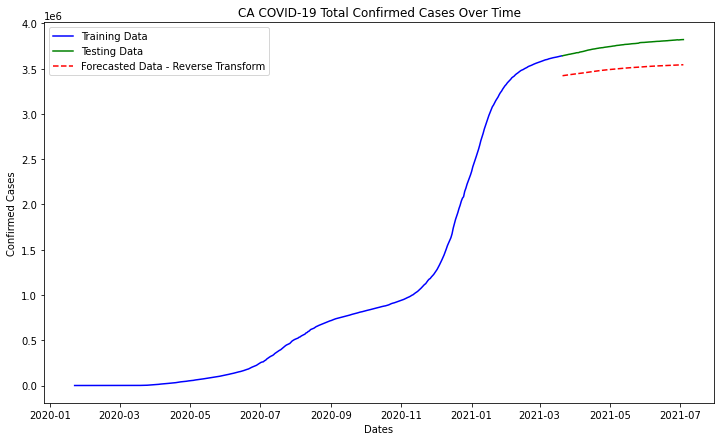

In [75]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Total Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(train_series, color='blue', label='Training Data')
plt.plot(test_series, color='green', label='Testing Data')
plt.plot(predicted_confirmed_cases_revtrans_series, color='red', linestyle='--', label='Forecasted Data - Reverse Transform')
plt.legend();

# Visualize only test and forecast data

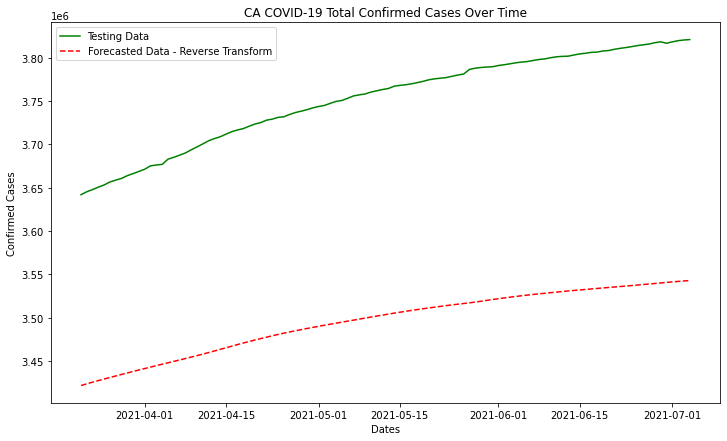

In [76]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Total Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(test_series, color='green', label='Testing Data')
plt.plot(predicted_confirmed_cases_revtrans_series, color='red', linestyle='--', label='Forecasted Data - Reverse Transform')
plt.legend();